In [16]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sympy import pprint

In [17]:
#INITIALIZE VARIABLES

d1 = 183.3 #joint 1 height [mm]
d2 = 737.31 #joint 2 radius [mm]
d3 = 387.8 #joint 3 radius [mm]
d4 = 95.5 #joint 4 radius [mm]
d5 = 115.5 #joint 5 radius [mm]
d6 = 76.8 #end effector offset
q = sp.pi/2 #standard 90 degree angle for ease of coding



In [18]:
#INITIALIZE SYMBOLS
thetai = sp.Symbol('theta_i')
t = sp.Symbol('t')
ai = sp.Symbol('a_i')
di = sp.Symbol('d_i')
alphai = sp.Symbol('alpha_i')
pi = sp.Symbol('pi')

In [19]:
#CREATE DH TABLE ROWS

thetas = sp.symbols('theta_1:7')
dh_theta = [thetas[0], thetas[1]+q, thetas[2], thetas[3]+q, thetas[4], thetas[5]]
dh_a = [0, d2, d3, 0, 0, 0]
dh_d = [d1, 0, 0, d4, d5, d6]
dh_alpha = [q, 0, 0, q, -q, 0]

In [20]:
#CREATE DH TABLE

dh_table = {
    "": ["to 1", "to 2", "to 3", "to 4", "to 5", "to 6"],
    thetai: [dh_theta[0],dh_theta[1],dh_theta[2],dh_theta[3],dh_theta[4],dh_theta[5]],
    ai: [dh_a[0],dh_a[1],dh_a[2],dh_a[3],dh_a[4],dh_a[5]],
    di: [dh_d[0],dh_d[1],dh_d[2],dh_d[3],dh_d[4],dh_d[5]],
    alphai: [dh_alpha[0],dh_alpha[1],dh_alpha[2],dh_alpha[3],dh_alpha[4],dh_alpha[5]]

}

df = pd.DataFrame(dh_table)
df

,,theta_i,a_i,d_i,alpha_i
0,to 1,theta_1,0.00,183.3,pi/2
1,to 2,theta_2 + pi/2,737.31,0.0,0
2,to 3,theta_3,387.80,0.0,0
3,to 4,theta_4 + pi/2,0.00,95.5,pi/2
4,to 5,theta_5,0.00,115.5,-pi/2
5,to 6,theta_6,0.00,76.8,0


In [21]:
#CREATE TRANSFORMATION MATRICES

#Array of all transformation matrices
A_array = [sp.zeros(4,4)]*6
for i in range(0,6):
    A_array[i] = sp.Matrix([
        [sp.cos(dh_theta[i]),-sp.sin(dh_theta[i])*sp.cos(dh_alpha[i]),sp.sin(dh_theta[i])*sp.sin(dh_alpha[i]),dh_a[i]*sp.cos(dh_theta[i])],
        [sp.sin(dh_theta[i]),sp.cos(dh_theta[i])*sp.cos(dh_alpha[i]),-sp.cos(dh_theta[i])*sp.sin(dh_alpha[i]),dh_a[i]*sp.sin(dh_theta[i])],
        [0,sp.sin(dh_alpha[i]),sp.cos(dh_alpha[i]),dh_d[i]],
        [0,0,0,1]
    ])

#Final transformation matrix A1*A2*A3*A4*A5*A6
A_final = A_array[0]
for i in range(1,6):
    A_final = A_final*A_array[i]

#Array of transformation matrix products [A1, A1*A2, A1*A2*A3,] etc
A_products = [A_array[0]]*6
for i in range(1,6):
    A_products[i] = A_products[i-1]*A_array[i]



In [22]:
#MATRIX SUBSTITUTION FUNCTIONS

#Substitutes theta values into given matrix and returns matrix 
def subs_function(matrix,sub_values):
    result = matrix.subs([
        (thetas[0],sub_values[0]),
        (thetas[1],sub_values[1]),
        (thetas[2],sub_values[2]),
        (thetas[3],sub_values[3]),
        (thetas[4],sub_values[4]),
        (thetas[5],sub_values[5])     
    ])
    return result

#Returns position vector of given transformation matrix and theta values
def subs_position_vector(matrix,sub_values):
    msubs = matrix.subs([
        (thetas[0],sub_values[0]),
        (thetas[1],sub_values[1]),
        (thetas[2],sub_values[2]),
        (thetas[3],sub_values[3]),
        (thetas[4],sub_values[4]),
        (thetas[5],sub_values[5])   
    ])
    result = sp.Matrix([
        [msubs[0,3]],
        [msubs[1,3]],
        [msubs[2,3]],
        [0],
        [0],
        [0]
    ])
    return result


In [23]:


#VALIDATE TRANSFORMATION MATRIX

#5 different sets of theta values for validation
val_matrix = sp.Matrix([
    [0, q, 0, 0, 0],
    [0, 0, q, 0, 0],
    [0, 0, 0, q, 0],
    [0, 0, 0, 0, q],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
])

#Array of resulting matrices
A_vals = [sp.zeros(4,4)]*5
for i in range(0,5):
    A_vals[i] = subs_function(A_final,val_matrix[:,i])


pos_vals = ["start position","first joint rotated 90 degrees","shoulder rotated 90 degrees","elbow rotated 90 degrees","wrist rotated 90 degrees"]
print("Transformation matrix validation")
for i in range(0,5):
    print("---------------")
    print(pos_vals[i])
    print(
        "x = ",((A_vals[i])[0,3]).round(2),#get x value from matrix i in A_vals array
        "y = ",((A_vals[i])[1,3]).round(2),#get y value from matrix i in A_vals array
        "z = ",((A_vals[i])[2,3]).round(2))#get z value from matrix i in A_vals array




Transformation matrix validation
---------------
start position
x =  0 y =  -172.30 z =  1423.91
---------------
first joint rotated 90 degrees
x =  172.30 y =  0 z =  1423.91
---------------
shoulder rotated 90 degrees
x =  -1240.61 y =  -172.30 z =  183.30
---------------
elbow rotated 90 degrees
x =  -503.30 y =  -172.30 z =  920.61
---------------
wrist rotated 90 degrees
x =  -115.50 y =  -172.30 z =  1308.41


In [24]:
#CREATE JACOBIAN


thetas_vector = sp.Matrix([thetas[0],thetas[1],thetas[2],thetas[3],thetas[4],thetas[5]])

# P = sp.Matrix([A_final[0,3],A_final[1,3],A_final[2,3]])

# Jv = P.jacobian(thetas_vector) #create 3x6 Jv matrix

Z = sp.zeros(3,7) #initialize 3x6 Jw matrix of zeros
Z[:,0] = sp.Matrix([0,0,1])

#replace values in Z with correct values from matrices in A_products array
for c in range(1,7):
    for r in range(0,3):
        Z[r,c] = (A_products[c-1])[r,2]

O = sp.zeros(3,7)
O[:,0] = sp.Matrix([0,0,0])
for c in range(1,7):
    for r in range(0,3):
        O[r,c] = (A_products[c-1])[r,3]


Jv = sp.zeros(3,6) #initialize 6x6 matrix of zeros
for c in range(0,6):
    Jv[:,c] = Z[:,c].cross(O[:,-1]-O[:,c])

#replace values with values from Jv and Jw
J= sp.zeros(6,6)
for c in range(0,6):
    for r in range(0,3):
        J[r,c] = Jv[r,c]
        J[r+3,c] = Z[r,c]






In [25]:
#PATH INPUTS

#initialize inputs
increment = 1 #time increment [s]
duration = 200 #total time [s]
arraysize = int(duration/increment) 
time = np.arange(0, duration, increment) #time array

theta_initial = sp.Matrix([0,3.14/4,3.14/4,0,3.14/4,0]) #Initial theta values (chosen at random)
ee_A_final = subs_position_vector(A_final,theta_initial) #Initial x,y,z position of end effector based on initial theta values

#initial end effector posiitons with respect to base frame [mm]
ee_x_initial = ee_A_final[0] 
ee_y_initial = ee_A_final[1]
ee_z_initial = ee_A_final[2]


#calculate distances traveled during paths
path1_distance = 50*sp.pi
path2_distance = 50
path3_distance = 100
path4_distance = 50
total_distance = path1_distance+path2_distance+path3_distance+path4_distance

#calculate time taken for each path
path1_time = (path1_distance/total_distance)*duration
path2_time = (path2_distance/total_distance)*duration
path3_time = (path3_distance/total_distance)*duration
path4_time = (path4_distance/total_distance)*duration

#calculate start time of each path
path1_start = 0
path2_start = path1_time.round(1)
path3_start = (path2_start+path2_time).round(1)
path4_start = (path3_start+path3_time).round(1)




In [26]:

#VELOCITY PROFILES

#equation for path 1 position with respect to time
path1_x = -(50*sp.cos((sp.pi/path1_time)*t))
path1_y = 0
path1_z = (50*sp.sin((sp.pi/path1_time)*t))

#equation for path 1 velocities with repect to time
path1_xdot = sp.diff(path1_x,t)
path1_ydot = 0
path1_zdot = sp.diff(path1_z,t)

#calculate path 2 velocities
path2_xdot = 0
path2_ydot = 0
path2_zdot = -50/path2_time

#calculate path 3 velocities
path3_xdot = -100/path3_time
path3_ydot = 0
path3_zdot = 0

#calculate path 4 velocities
path4_xdot = 0
path4_ydot = 0
path4_zdot = 50/path4_time

#create xdot master matrix for all paths 
XDOT = sp.Matrix([
    [path1_xdot, path2_xdot, path3_xdot, path4_xdot],
    [path1_ydot, path2_ydot, path3_ydot, path4_ydot],
    [path1_zdot, path2_zdot, path3_zdot, path4_zdot],
    [0,0,0,0],
    [0,0,0,0],
    [0,0,0,0]])



In [27]:

#initialize array sizes for each path (for use in for loops)
path1_arraysize = int(path1_time/increment)
path2_arraysize = int(path2_time/increment)
path3_arraysize = int(path3_time/increment)
path4_arraysize = int(path4_time/increment)




In [28]:
#calculate initial inverse jacobian to obtain initial thetadot values


j_initial = (subs_function(J,theta_initial)) #initial  jacobian

if j_initial.det()<0.001:

    jinv_initial = j_initial.pinv()
else:
    jinv_initial = j_initial.inv()

thetadot_initial = jinv_initial*((XDOT[:,0]).subs([(t,0)])) #initial thetadot values















In [29]:
#CALCULATE ANGULAR POSITIONS AND SPEEDS

#Create theta and thetadot arrays and populate with initial values
THETA = sp.zeros(6,arraysize)
THETA[:,0] = theta_initial
THETADOT = sp.zeros(6,arraysize)
THETADOT[:,0] = thetadot_initial

#Fill theta and thetadot arrays
for c in range(1,arraysize):
    t_var = time[c]
    for r in range(0,6):
        THETA[r,c] = (THETA[r,c-1]+((THETADOT[r,c-1])*increment)).round(10)#rounded to speed up program run time
    JSUBS = subs_function(J,THETA[:,c])

    if JSUBS.det()<0.0001:
        jinv = JSUBS.pinv()
    else:
        jinv = JSUBS.inv()
    
    if t_var < path2_start:
        thetadot_temp = jinv*((XDOT[:,0]).subs([(t, t_var)]))
    elif path2_start <= t_var < path3_start:
        thetadot_temp = jinv*XDOT[:,1]
    elif path3_start <= t_var < path4_start:
        thetadot_temp = jinv*XDOT[:,2]
    else:
        thetadot_temp = jinv*XDOT[:,3]

    for r in range(0,6):
        THETADOT[r,c] = thetadot_temp[r]

    

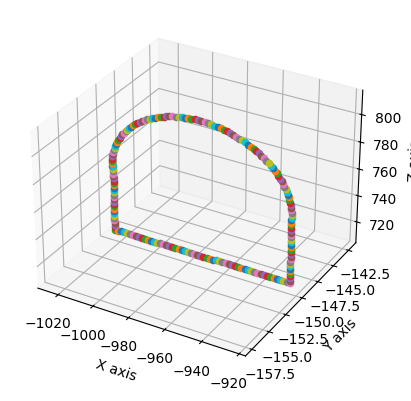

Matrix([
[-1024.40589, -1024.40177, -1024.33417, -1024.20316, -1024.00891, -1023.75165, -1023.4317, -1023.04945, -1022.60538, -1022.10003, -1021.53404, -1020.90809, -1020.22299, -1019.47956, -1018.67875, -1017.82154, -1016.90901, -1015.9423, -1014.92262, -1013.85124, -1012.72951, -1011.55883, -1010.34067, -1009.07657, -1007.76811, -1006.41695, -1005.02478, -1003.59338, -1002.12453, -1000.62011, -999.08202,  -997.5122, -995.91266, -994.28541, -992.63253, -990.95611, -989.25829, -987.54124, -985.80712, -984.05816, -982.29659, -980.52465, -978.74459, -976.95869, -975.16923, -973.37849, -971.58876, -969.80233, -968.02146, -966.24844, -964.48554, -962.73499, -960.99904, -959.27991, -957.57978, -955.90084, -954.24522, -952.61504, -951.01237, -949.43927, -947.89775, -946.38976, -944.91724, -943.48207, -942.08607, -940.73103, -939.41867, -938.15067, -936.92865, -935.75417, -934.62872, -933.55373, -932.53058, -931.56057, -930.64494, -929.78485,  -928.9814, -928.23561, -927.54843, -926.92073, -9

In [30]:
#PLOTTING END EFFECTOR POSITION
end_effector_xyz = sp.zeros(3,arraysize)#initialize matrix of xyz positions 

#sub theta array values into final transformation matrix to get end effector xyz values
for c in range(0,arraysize):
    Asubs = subs_function(A_final,THETA[:,c])
    end_effector_xyz[0,c] = (Asubs[0,3]).round(5)
    end_effector_xyz[1,c] = (Asubs[1,3]).round(5) #compensating for pencil length
    end_effector_xyz[2,c] = (Asubs[2,3]).round(5)



#PLOT END EFFECTOR PATH
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(0,arraysize):
    
    ax.scatter([end_effector_xyz[0,i]], [end_effector_xyz[1,i]], [end_effector_xyz[2,i]])


# Set labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')


# Show plot
plt.show()

end_effector_xyz
